In [5]:
import spacy
# Análisis de componentes principales
from sklearn.decomposition import PCA
# Clustering jerárquico
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
# Nubes de palabras
from wordcloud import WordCloud

In [6]:
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
import glob, os

In [7]:
# Descomentar esta línea para descargar los embeddings españoles
# !python -m spacy download es_core_news_md
# Modelo con embeddings
nlp = spacy.load('es_core_news_md')

In [17]:
# Guardamos todos los archivos en una lista 
# de documentos "spacy" con el texto
# los documentos tokenizan, etc. automáticamente
textos = []
# También almacenamos los títulos
titulos = []
for fn in glob.glob('datos/*'):
    with open(fn) as f:
        titulos.append(os.path.basename(fn))
        textos.append(nlp(f.read()))
len(titulos), titulos

(44,
 ['Escuela',
  'Normas',
  'La selva de los relojes',
  'Angulo eterno',
  'Suite de los espejos',
  '(Con la frente en el suelo)',
  'Tengo miedo a perder',
  'Canción',
  'Chopo y torre',
  'Suite del agua.',
  'La oración de las rosas.',
  'Canción de cuna',
  'Surtidores',
  'Tres historietas',
  'Luna y panorama de los insectos',
  'Noche',
  'Canto nocturno de los marineros andaluces',
  'Soledad',
  'Miguel Pizarro',
  'Sonetos',
  'Canción, Si tú oyeras',
  'El poeta pide a su amor',
  'Epitafio a Isaac Albéniz',
  'Tierra y luna',
  'Se ha quebrado el sol',
  'Cada canción',
  'Estampa en el cielo',
  'Herbarios',
  'Este es el prólogo.',
  'Estío',
  'A Carmela, la peruana',
  'Canción de la muerte pequeña',
  'Oda a Salvador Dalí',
  'En la amplia cocina,',
  'Oda al Santísimo Sacramento del altar',
  'Soledad insegura',
  'Omega',
  '(Siento)',
  'Tardecilla del Jueves Santo',
  'Canción de la desesperanza',
  'La sirena y el carabinero',
  'Canción Para Alfredo Mario 

In [9]:
# Hay un vector pre-entrenado (word embedding) asociado con cada palabra española
# y un vector que representa la media de todos los vectores de palabra
# en cada documento

# Almacenamos todos los vectores de documentos en una matriz
vects = np.vstack([t.vector for t in textos])

In [10]:
# Clustering jerárquico de los vectores de documento
lnk = linkage(vects, method='ward')

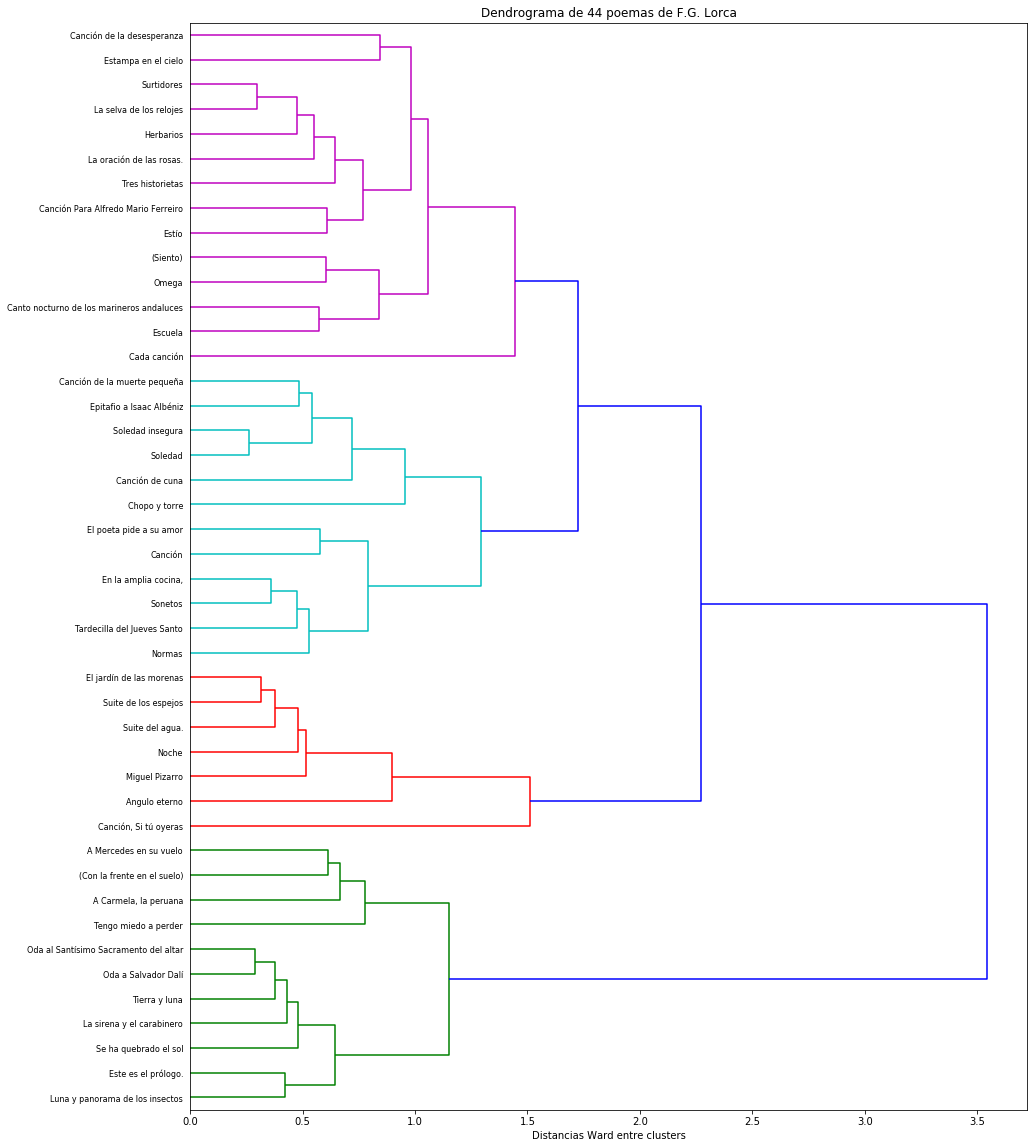

In [22]:
# Dendrograma de los documentos

# Elegimos una distancia de corte
# para resaltar los clusters principales
dist_corte = 1.6

fig, ax = plt.subplots(figsize=(15, 20))
opciones = {'ax': ax, 'orientation': "right", 'labels': titulos,
            'p': 5, 'color_threshold': dist_corte,
           }
plt.title('Dendrograma de 44 poemas de F.G. Lorca')
plt.xlabel('Distancias Ward entre clusters')
dendrogram(lnk, **opciones)
# Guardamos la imagen
plt.savefig('figuras/dendrograma_embeddings.png', dpi=150)
plt.show()

In [12]:
# Lista de clusters principales
# Los determinamos con la misma distancia de corte
# que en el dendrograma
clsts = fcluster(lnk, dist_corte, criterion='distance')
clsts

array([4, 3, 4, 2, 2, 1, 1, 3, 3, 2, 4, 3, 4, 4, 1, 2, 4, 3, 2, 3, 2, 3,
       3, 1, 1, 4, 4, 4, 1, 4, 1, 3, 1, 3, 1, 3, 4, 4, 3, 4, 1, 4, 1, 2],
      dtype=int32)

In [13]:
def get_cluster(textos, titulos, labels, indice):
    ''' Función que devuelve los documentos y títulos de un cluster determinado '''
    cluster_texts = []
    cluster_titulos = []
    for i, t in enumerate(textos):
        if labels[i] == indice + 1:
            cluster_texts.append(t)
            cluster_titulos.append(titulos[i])
    return cluster_texts, cluster_titulos

In [14]:
def draw_cluster_spacy(textos, titulos, labels, indice, archivo='', **kwargs):
    ''' Función que dibuja la nube de puntos correspondiente a un cluster '''
    txts_cluster, _ = get_cluster(textos, titulos, labels, indice)
    pals = ' '. join([
        ' '.join([w.text.lower() for w in txt if w.is_alpha and not w.is_stop and len(w.text) > 3])
            for txt in txts_cluster])
    wordcloud = WordCloud(**kwargs).generate(pals)

    # Display the generated image:
    plt.title(f'Cluster {indice + 1}')
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()
    if archivo:
        wordcloud.to_file(archivo + '.png' )

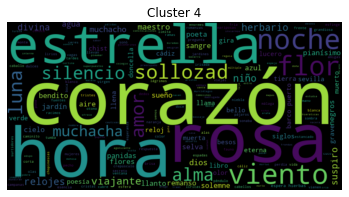

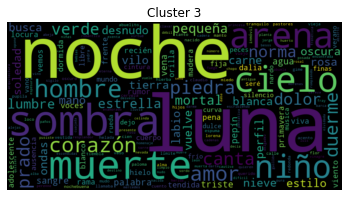

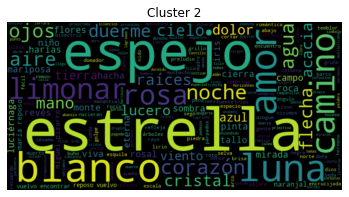

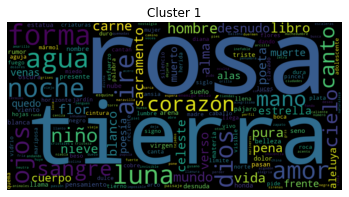

In [15]:
# Nubes de palabras para cada cluster
# Se imprimen en orden inverso al número de cluster, para que coincidan con el orden
# en el dendograma
for i in range(3, -1, -1):
    fn = f"figuras/cluster_embeddings_{i+1}"
    draw_cluster_spacy(textos, titulos, clsts, i, archivo=fn, width=800, height=400)

In [23]:
# Usamos "Análisis de componentes principales" para reducir cada vector de documento a dos dimensiones
# de forma que puedan graficarse
pca = PCA( n_components=2)
pca_res = pca.fit_transform(vects)

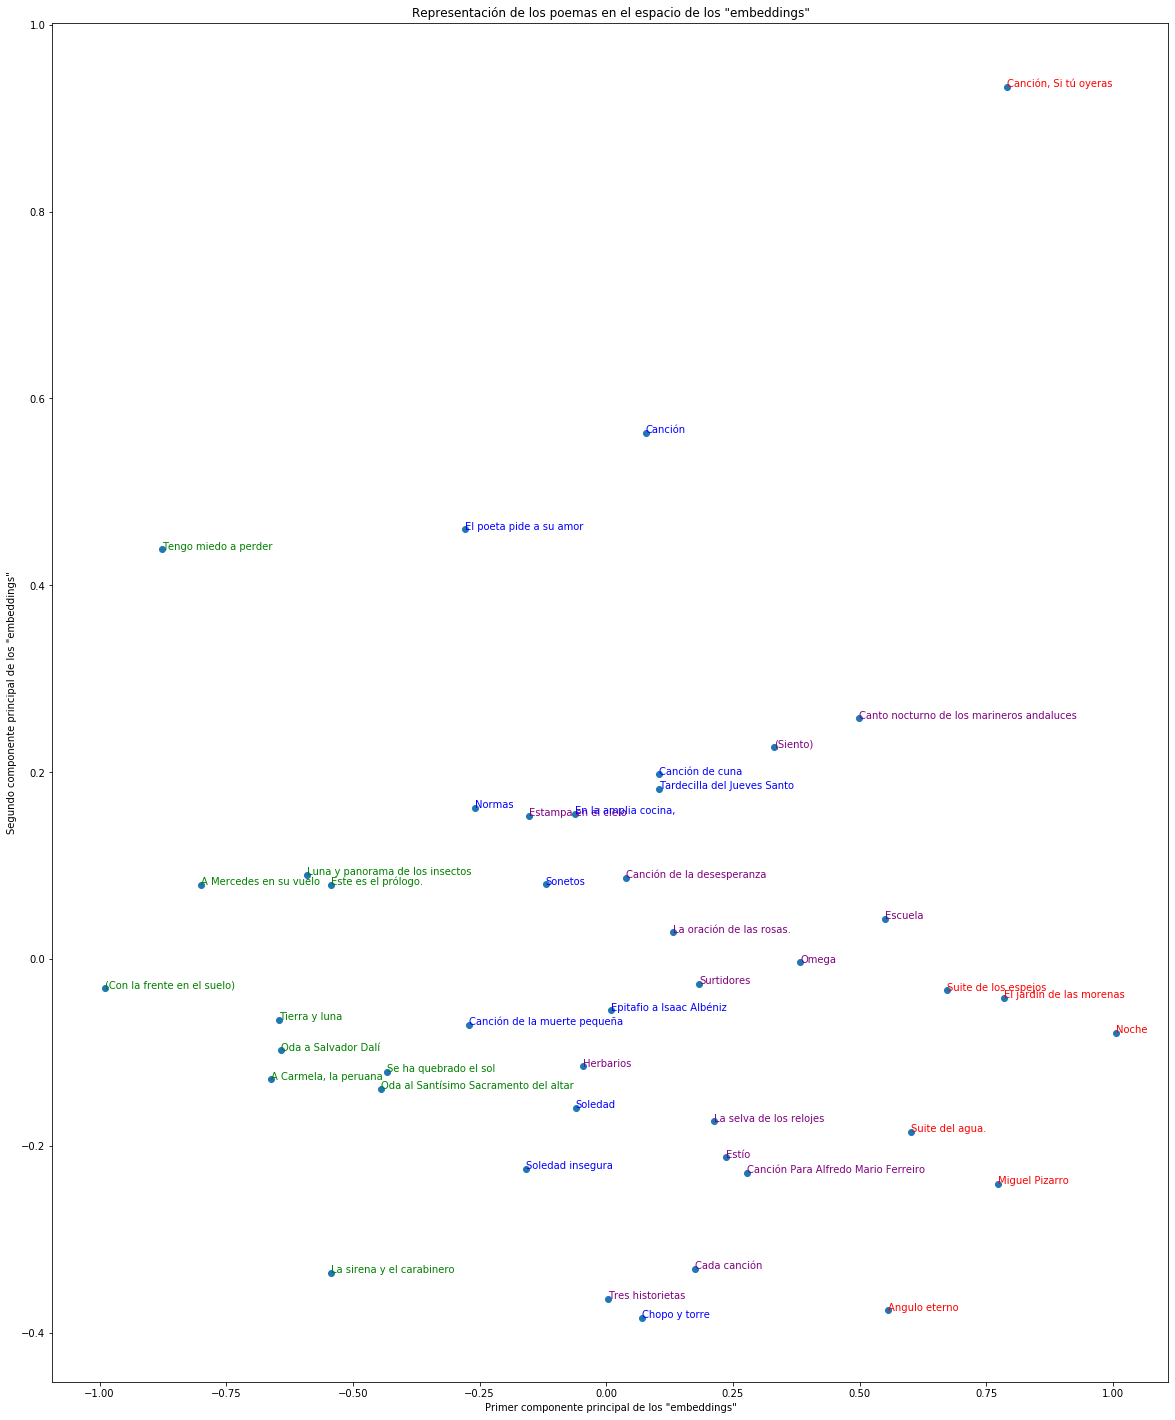

In [25]:
# Colores para cada cluster, equivalentes a los del dendrograma
colores = dict(zip(range(1, 5), ['green', 'red', 'blue','purple']))

# Ahora podemos dibujar cada vector en un espacio bidimensional
fig, ax = plt.subplots(figsize=(20, 25))
plt.title('Representación de los poemas en el espacio de los "embeddings"')
plt.xlabel('Primer componente principal de los "embeddings"')
plt.ylabel('Segundo componente principal de los "embeddings"')
ax.scatter(pca_res[:, 0], pca_res[:, 1])
# Escribimos cada título con un color correspondiente a su cluster
for i, word in enumerate(titulos):
    ax.annotate(word, xy=(pca_res[i, 0], pca_res[i, 1]), c=colores[clsts[i]])
# Guardamos la imagen
plt.savefig('figuras/nube_puntos.png', dpi=300)
plt.show()